In [1]:
from torch_lr_finder import LRFinder
from models import ENet
import numpy as np
import os
model = ENet('efficientnet-b1')
data_dir = '../input/alaska2-image-steganalysis'
sample_size = 5000
val_size = int(sample_size*0.25)


jmipod = sorted([f'../input/alaska2-image-steganalysis/JMiPOD/{x}'
                 for x in os.listdir('../input/alaska2-image-steganalysis/JMiPOD/')],
                key=lambda x: x.split('/')[-1].split('.')[0])[:sample_size]
juniward = sorted([f'../input/alaska2-image-steganalysis/JUNIWARD/{x}'
                   for x in os.listdir('../input/alaska2-image-steganalysis/JUNIWARD/')])[:sample_size]
uerd = sorted([f'../input/alaska2-image-steganalysis/UERD/{x}'
               for x in os.listdir('../input/alaska2-image-steganalysis/UERD/')])[:sample_size]
covers = sorted([f'../input/alaska2-image-steganalysis/Cover/{x}'
                 for x in os.listdir('../input/alaska2-image-steganalysis/Cover/')])[:sample_size]
test = [f'../input/alaska2-image-steganalysis/Test/{x}'
        for x in os.listdir('../input/alaska2-image-steganalysis/Test/')]

labels = {f'{id}': 0 for id in covers}
labels.update({f'{id}': 1 for id in jmipod})
labels.update({f'{id}': 2 for id in juniward})
labels.update({f'{id}': 3 for id in uerd})

items = np.array(list(labels.items()))
np.random.shuffle(items)
labels = {idx_: int(label) for (idx_, label) in items}
train_keys = list(labels.keys())


import albumentations as albu
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader
from dataset import ALASKAData2
p=0.5
train_data = DataLoader(
    ALASKAData2(
        train_keys, labels, albu.Compose([
            albu.Resize(*(224,224)),
            albu.HorizontalFlip(p=p),
            albu.VerticalFlip(p=p),
            albu.ToFloat(255),
            ToTensorV2()  # albu.Lambda(image=to_tensor)
        ])
    ), batch_size=16, shuffle=True, num_workers=2)




Loaded pretrained weights for efficientnet-b1


In [62]:
import cv2
from skimage.io import imshow
from skimage.exposure import (rescale_intensity, 
                              adjust_sigmoid, 
                              equalize_adapthist)
from matplotlib import pyplot as plt
from scipy import fftpack

def show_images(images: list):
    fig, ax = plt.subplots(1, len(images), figsize=(18,16))
    for i in range(len(images)):
        ax[i].imshow(images[i][0])
        ax[i].axis(False)
        ax[i].set_title(f"{images[i][1]}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


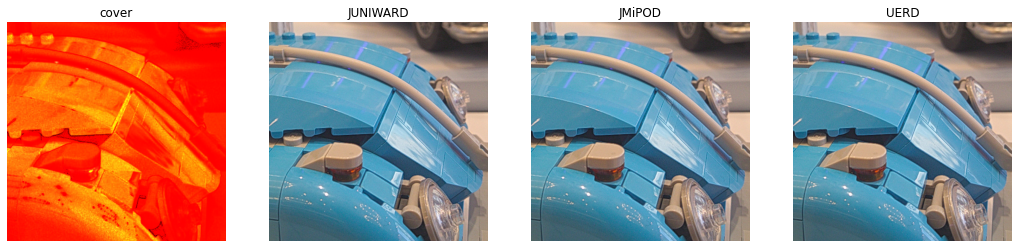

In [129]:
#idx = np.random.randint(len(covers))

image = cv2.imread(covers[idx])[...,::-1]
image_juniward = cv2.imread(juniward[idx])[...,::-1]
image_jmipod = cv2.imread(jmipod[idx])[...,::-1]
image_uerd = cv2.imread(jmipod[idx])[...,::-1]


show_images([(fftpack.dct(image/255)**2, 'cover'),
             (image_juniward,'JUNIWARD'),
             (image_jmipod, 'JMiPOD'),
             (image_uerd,'UERD')])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


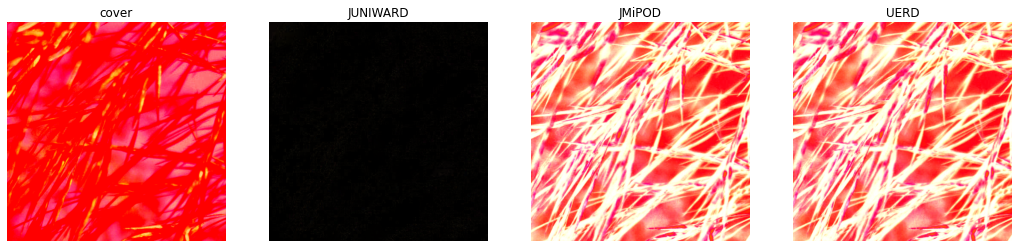

In [124]:
COLORSPACE = cv2.COLOR_RGB2YCrCb
channel = 0
image_other = fftpack.dct(cv2.cvtColor(equalize_adapthist(image).astype(np.float32),
                                             COLORSPACE))
juniward_other = fftpack.dct(cv2.cvtColor(equalize_adapthist(image_juniward).astype(np.float32),
                                             COLORSPACE))
jmipod_other = rescale_intensity(cv2.cvtColor(equalize_adapthist(image_jmipod).astype(np.float32),
                                             COLORSPACE),
                                (0, 1))
uerd_other = rescale_intensity(cv2.cvtColor(equalize_adapthist(image_uerd).astype(np.float32),
                                             COLORSPACE),
                                (0, 1))
show_images([(image_other, 'cover'),
             (abs(image_other-juniward_other),'JUNIWARD'),
             (abs(image_other-jmipod_other), 'JMiPOD'),
             (abs(image_other-uerd_other),'UERD')])

In [126]:
(image_other)**2

array([[[8.0995111e+00, 1.2678774e-01, 5.9635947e-03],
        [9.0244894e+00, 5.9918314e-02, 3.2735898e-06],
        [1.0669444e+01, 3.2670503e-03, 1.7672701e-02],
        ...,
        [7.2056580e+00, 3.2269913e-01, 4.1564531e-03],
        [7.8852944e+00, 2.8891024e-01, 1.1145290e-03],
        [8.1263409e+00, 2.7881515e-01, 9.4293733e-04]],

       [[1.0208317e+01, 1.6738841e-02, 1.1014018e-02],
        [1.1168457e+01, 6.4885279e-04, 3.2029100e-02],
        [1.2143206e+01, 6.0249292e-03, 6.2936500e-02],
        ...,
        [7.5334668e+00, 3.4199598e-01, 5.0935927e-05],
        [8.1194420e+00, 3.2687622e-01, 7.6338899e-04],
        [8.4280701e+00, 3.0844837e-01, 1.2806999e-03]],

       [[1.2306724e+01, 4.1684089e-03, 8.0402732e-02],
        [1.2775215e+01, 1.2724572e-02, 1.0070412e-01],
        [1.2911802e+01, 1.5998693e-02, 1.0698734e-01],
        ...,
        [8.2956877e+00, 3.2212031e-01, 1.1728457e-02],
        [9.0299759e+00, 2.7122307e-01, 1.7679980e-02],
        [9.4963226e+00

In [109]:
cv2.cvtColor(equalize_adapthist(image).astype(np.float32),
                                             COLORSPACE).shape

(512, 512, 3)